<h1> Imports </h1>

In [1]:
from read_data import read_dataset_1, translate_1, read_dataset_3, translate_3
from models import SimulationEnvironment
from optimizer import BaseGA, SimpleAgentGA
from agent import GreedyAgent, AgentSimulator
from visualize import reformat_result, visualize, visualize_schedule, fitness_history_plot
import random
import copy
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, LpInteger, PULP_CBC_CMD

<h1>Parameters</h1>


In [2]:
# Parameters
max_generations = 100
earliest_time_slot = 200
last_time_slot = 5000
population_size = 10
offspring_amount = 20

order_amount = 10

<h1>Input Data</h1>
<h4>Choose 1 of the following</h4>

Dataset 1 (Job Shop Scheduling)

In [3]:
input, orders, instance = read_dataset_1(use_instance=13, order_amount=order_amount, earliest_time=earliest_time_slot, last_time=last_time_slot)
recipes, workstations, resources, tasks, orders_model = translate_1(instance, orders, earliest_time_slot, last_time_slot)

Dataset 3, Resource Constrained (Job Shop Scheduling)

In [10]:
input, orders, instance = read_dataset_3(order_amount=order_amount, earliest_time=earliest_time_slot, last_time=last_time_slot)
recipes, workstations, resources, tasks, orders_model = translate_3(instance, n_workstations=10, generated_orders=orders, earliest=earliest_time_slot, latest=last_time_slot) # for dataset 3, the amount of available machines has to be declared (not included with the data)

<h1> Simulation Environment Setup </h1>

In [4]:
env = SimulationEnvironment(workstations, tasks, resources, recipes)

<h1> LP </h1>

In [12]:
def get_all_workstations_for_task(task_id, workstations, env):
    combinations = []
    for w in workstations:
        for tt in env.get_workstation(w).tasks:
            if task_id == tt[0]:
                combinations.append(w)
    return combinations

def get_duration(task_id, workstation, combinations):
    return combinations[(task_id, workstation)]
# create problem
problem = LpProblem('SchedulingProblem', LpMinimize)
# create variables
lp_workstations = []
for workstation in env.workstations:
    lp_workstations.append(workstation.id)
lp_tasks = []
for task in env.tasks:
    lp_tasks.append(task.id)
lp_orders = []
for order in orders_model:
    lp_orders.append(order.id)
lp_resources = []
for resource in env.resources:
    lp_resources.append(resource.id)
# gather all possible combinations of tasks and workstations
possible_combinations = []
for w in lp_workstations:
    for t in lp_tasks:
        for tt in env.get_workstation(w).tasks:
            if t == tt[0]:
                possible_combinations.append((w, t))
durations = dict()
# gather the duration of all possible task/workstation combinations
for combination in possible_combinations:
    durations[combination] = env.get_duration(combination[1], combination[0])
#NOTE: ignoring the possibility of multiple recipes for each resource for now and just use first
lp_jobs = []
lp_assignments = []
lp_start_times = []
lp_durations = dict()
i = 0
for order in orders_model:
    for resource in order.resources:
        tasks = env.get_all_tasks_for_recipe(resource.recipes[0].id)
        for task in tasks:
            # get all possible combinations for task and pick random starting combination
            combos = []
            for combination in possible_combinations:
                if combination[1] == task.id:
                    combos.append(combination)
            # task id, w/t combination, x_dt, x_lt
            lp_jobs.append([task.id, order.delivery_time, order.latest_acceptable_time])
            lp_assignments.append(LpVariable(f'a{i}', lowBound=min(lp_workstations), upBound=max(lp_workstations), cat=LpInteger))
            lp_start_times.append(LpVariable(f's{i}', lowBound=earliest_time_slot, upBound=last_time_slot, cat=LpInteger))
            lp_durations[task.id] = dict()
            for workstation in lp_workstations:
                lp_durations[task.id][workstation] = env.get_duration(task.id, workstation)
            i+=1

# assignments = LpVariable.dicts('assignments', [(a, s) for a in lp_assignments for s in lp_start_times], lowBound=earliest_time_slot, upBound=last_time_slot, cat=LpInteger)
# NOTE: first function added to the LpProblem needs to be objective
# add objective
problem += (lpSum([lp_start_times[i] + lp_durations[lp_jobs[i][0]][lp_assignments[i]] - lp_jobs[i][1] for i in range(len(lp_jobs))]), 'Minimize_tardy_jobs') 
# NOTE: add constraints here
for i in range(len(lp_jobs)):
    problem += lp_durations[lp_jobs[i][0]][lp_assignments[i]] > 0

# Solve
#problem.writeLP('SchedulingProblem.lp') # in case problem should be exported
#solver = PULP_CBC_CMD(msg=1, mip_start=1)
#problem.solve(solver)
problem.solve()
print(f'Status: {LpStatus[problem.status]}')
# print result
for i in range(len(lp_assignments)):
    print(f'Scheduled job {i} on workstation {lp_assignments[i].value()} with start time {lp_start_times[i].value()}')


KeyError: a0

<h1>Optimizer</h1>

Config 1 - Test with One Point Crossover

Current generation: 0, Current Best: 300, not feasible
Current generation: 1, Current Best: 298, not feasible
Current generation: 2, Current Best: 294, not feasible
Current generation: 3, Current Best: 289, not feasible
Current generation: 4, Current Best: 288, not feasible
Current generation: 5, Current Best: 287, not feasible
Current generation: 6, Current Best: 287, not feasible
Current generation: 7, Current Best: 286, not feasible
Current generation: 8, Current Best: 286, not feasible
Current generation: 9, Current Best: 284, not feasible
Current generation: 10, Current Best: 284, not feasible
Current generation: 11, Current Best: 284, not feasible
Current generation: 12, Current Best: 283, not feasible
Current generation: 13, Current Best: 283, not feasible
Current generation: 14, Current Best: 282, not feasible
Current generation: 15, Current Best: 281, not feasible
Current generation: 16, Current Best: 280, not feasible
Current generation: 17, Current Best: 280, not feasible
Cu

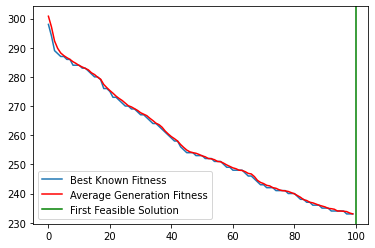

In [5]:
optimizer = BaseGA(env)
optimizer.set_minimize()
# optional (in this case, all options given are the default option, if the configuration step is skipped)
optimizer.configure('tardiness', 'onepointcrossover', 'roulettewheel', 'randomize')
# choose an input generator (optional) -> decides how the data gets converted into the optimizer format
# optimizer.set_input_generator('SameLengthAlternativesGenerator')
# all parameters after offspring_amount are optional (in this case -> verbose=True)
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
workstation_assignments = reformat_result(result, orders, env)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)

Config 2 - Test with Two Point Crossover

Current generation: 0, Current Best: 285, not feasible
Current generation: 1, Current Best: 285, not feasible
Current generation: 2, Current Best: 282, not feasible
Current generation: 3, Current Best: 278, not feasible
Current generation: 4, Current Best: 277, not feasible
Current generation: 5, Current Best: 275, not feasible
Current generation: 6, Current Best: 274, not feasible
Current generation: 7, Current Best: 274, not feasible
Current generation: 8, Current Best: 273, not feasible
Current generation: 9, Current Best: 273, not feasible
Current generation: 10, Current Best: 271, not feasible
Current generation: 11, Current Best: 270, not feasible
Current generation: 12, Current Best: 270, not feasible
Current generation: 13, Current Best: 269, not feasible
Current generation: 14, Current Best: 269, not feasible
Current generation: 15, Current Best: 268, not feasible
Current generation: 16, Current Best: 268, not feasible
Current generation: 17, Current Best: 266, not feasible
Cu

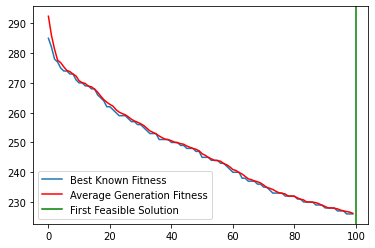

In [6]:
optimizer = BaseGA(env)
optimizer.set_minimize()
# optional (in this case, all options given are the default option, if the configuration step is skipped)
optimizer.configure('tardiness', 'twopointcrossover', 'roulettewheel', 'randomize')
# choose an input generator (optional) -> decides how the data gets converted into the optimizer format
#optimizer.set_input_generator('SameLengthAlternativesGenerator')
# all parameters after offspring_amount are optional (in this case -> verbose=True)
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
workstation_assignments = reformat_result(result, orders, env)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)

Config 3 - Only valid mutations for time slots

1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
2
<class 'list'>
1
<class 'list'>
1
<class 'list'>
Current generation: 0, Current Best: 211, not feasible
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
2
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
2
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
Current generation: 1, Current Best: 211, not feasible
1
<class 'list'>
1
<class 'list'>
2
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
2
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
1
<class 'list'>
Curren

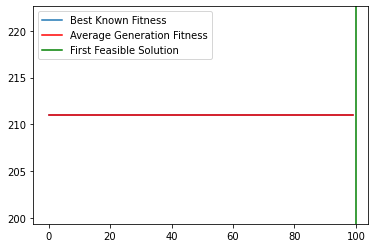

In [7]:
optimizer = BaseGA(env)
optimizer.configure('tardiness', 'twopointcrossover', 'roulettewheel', 'onlyfeasibletimeslot')
last_time_slot = 0
for order in orders:
    if order[1] > last_time_slot:
        last_time_slot = order[1]
# all parameters after offspring_amount are optional (in this case -> verbose=True)
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
workstation_assignments = reformat_result(result, orders, env)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)

Config 4 - Randomized Mutation with "open" Planning Horizon

Current generation: 0, Current Best: 297, not feasible
Current generation: 1, Current Best: 297, not feasible
Current generation: 2, Current Best: 291, not feasible
Current generation: 3, Current Best: 289, not feasible
Current generation: 4, Current Best: 287, not feasible
Current generation: 5, Current Best: 285, not feasible
Current generation: 6, Current Best: 285, not feasible
Current generation: 7, Current Best: 283, not feasible
Current generation: 8, Current Best: 281, not feasible
Current generation: 9, Current Best: 280, not feasible
Current generation: 10, Current Best: 278, not feasible
Current generation: 11, Current Best: 278, not feasible
Current generation: 12, Current Best: 277, not feasible
Current generation: 13, Current Best: 274, not feasible
Current generation: 14, Current Best: 273, not feasible
Current generation: 15, Current Best: 273, not feasible
Current generation: 16, Current Best: 273, not feasible
Current generation: 17, Current Best: 273, not feasible
Cu

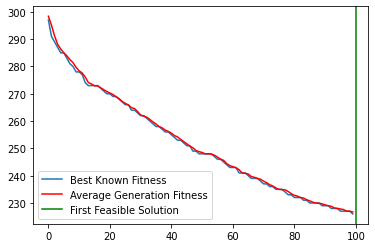

In [8]:
optimizer = BaseGA(env)
optimizer.configure('tardiness', 'twopointcrossover', 'roulettewheel', 'randomize')
last_time_slot = 0
for order in orders:
    if order[1] > last_time_slot:
        last_time_slot = order[1]
# all parameters after offspring_amount are optional (in this case -> verbose=True)
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
workstation_assignments = reformat_result(result, orders, env)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)

<h1> Agents </2>

Greedy

In [9]:
agent = GreedyAgent(env)
simulator = AgentSimulator()
schedule, schedule_count = simulator.simulate(agent, orders_model)
print(f'Scheduled {schedule_count}/{len(orders_model)} Orders')
visualize_schedule(schedule, env)

Scheduled 10/10 Orders


Greedy with changing sequence

In [10]:
def change_order(orders):
    p1 = random.randint(0, len(orders) -2)
    p2 = random.randint(p1, len(orders) -1)
    selected = copy.deepcopy(orders[p1 : p2 +1])
    selected.reverse()
    for i in range(len(selected)):
        orders[p1 + i] = copy.deepcopy(selected[i])

agent = GreedyAgent(env)
simulator = AgentSimulator()
n_generations = 10
best = None
sequence = copy.deepcopy(orders_model)
for gen in range(n_generations):
    simulator = AgentSimulator()
    schedule, schedule_count = simulator.simulate(agent, sequence)
    if not best or best[1] < schedule_count:
        best = [schedule, schedule_count, copy.deepcopy(sequence)]
    change_order(sequence)
print(f'Scheduled {best[1]}/{len(best[2])} Orders')
visualize_schedule(best[0], env)



Scheduled 10/10 Orders


Greedy with order sequence optimization

Current generation: 0, Current Best: 10
Current generation: 1, Current Best: 10
Current generation: 2, Current Best: 10
Current generation: 3, Current Best: 10
Current generation: 4, Current Best: 10
Current generation: 5, Current Best: 10
Current generation: 6, Current Best: 10
Current generation: 7, Current Best: 10
Current generation: 8, Current Best: 10
Current generation: 9, Current Best: 10
Current generation: 10, Current Best: 10
Current generation: 11, Current Best: 10
Current generation: 12, Current Best: 10
Current generation: 13, Current Best: 10
Current generation: 14, Current Best: 10
Current generation: 15, Current Best: 10
Current generation: 16, Current Best: 10
Current generation: 17, Current Best: 10
Current generation: 18, Current Best: 10
Current generation: 19, Current Best: 10
Current generation: 20, Current Best: 10
Current generation: 21, Current Best: 10
Current generation: 22, Current Best: 10
Current generation: 23, Current Best: 10
Current generation: 24, Cu

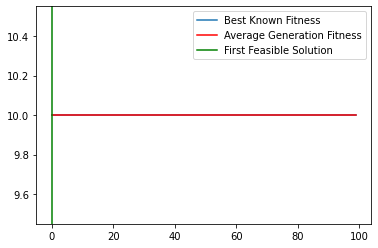

In [11]:
agent = GreedyAgent(env)
simulator = AgentSimulator()
sequence = copy.deepcopy(orders_model)
optimizer = SimpleAgentGA(env, agent, simulator)
optimizer.configure('ordercount', 'onepointcrossover', 'roulettewheel', 'orderchange', 'agent') # change individual type
optimizer.evaluation_method.set_simulator(simulator)
optimizer.evaluation_method.set_agent(agent)
optimizer.set_maximize()
optimizer.set_sequence(sequence)
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
schedule, schedule_count = simulator.simulate(agent, result.genes)
print(f'Scheduled {schedule_count}/{len(orders_model)} Orders')
# for some reason visualization is very slow on this one
#visualize_schedule(schedule, env)
fitness_history_plot(best_fitness_history, average_fitness_history, feasible_gen, best_generation_history)